# first excited state check

check the consistency between the ERE and first excited states for P011 and P111 frames

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns

sns.set_theme(context='talk', 
              style='whitegrid', 
              palette='Set2',
              font_scale=1.4, 
              rc={'figure.figsize': (14, 6)})

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly
pio.templates.default = 'plotly_white+presentation'



import scipy.optimize
import scipy.constants as sc

hbarc = sc.hbar*sc.speed_of_light/sc.giga/sc.electron_volt / sc.femto

from scipy.interpolate import InterpolatedUnivariateSpline


import json
import os
import glob

import sys
sys.path.append('../src')
from luscher_lib import Luscher_zeta, Kcot_luscher

from tqdm import tqdm

# load data

In [3]:
df_conf = pd.read_csv('../data/CLS_conf_inf.csv')
df_conf['a2 [fm2]'] = df_conf['a [fm]'].apply(lambda x: x**2)
df_conf['a_inv [GeV]'] = (hbarc / df_conf['a [fm]']).round(3) # add lattice unit
df_conf

,Label,N_f,beta,kappa,size_L,size_T,bdy.cond.,a [fm],m_pi [MeV],L [fm],m_pi L,m_B [GeV],N_conf,N_tsrc,N_meas,N_LapH,a2 [fm2],a_inv [GeV]
0,N300,3,3.70,0.137000,48,128,open,0.0498,422,2.4,5.1,1.19,2047,12,24564,32,0.002480,3.962
1,N202,3,3.55,0.137000,48,128,open,0.0642,412,3.1,6.4,1.17,899,8,10788,68,0.004122,3.074
2,H200,3,3.55,0.137000,32,96,open,0.0642,419,2.1,4.4,1.19,2000,8,16000,20,0.004122,3.074
3,B450,3,3.46,0.136890,32,64,periodic,0.0762,417,2.4,5.2,1.18,1612,8,25762,32,0.005806,2.590
4,H101,3,3.40,0.136760,32,96,open,0.0865,417,2.8,5.9,1.16,2016,4,12096,48,0.007482,2.281
5,U103,3,3.40,0.136760,24,128,open,0.0865,414,2.1,4.4,1.18,5658,5,45264,20,0.007482,2.281
6,A653,3,3.34,0.136572,24,48,periodic,0.0992,424,2.4,5.1,1.16,5050,4,40400,32,0.009841,1.989
7,E5,2,5.30,0.136250,32,64,periodic,0.0658,436,2.1,4.7,1.29,2000,4,16000,30,0.004330,2.999
8,E1,2,5.30,0.135500,32,64,periodic,0.0658,978,2.1,10.4,2.03,168,8,2688,30,0.004330,2.999


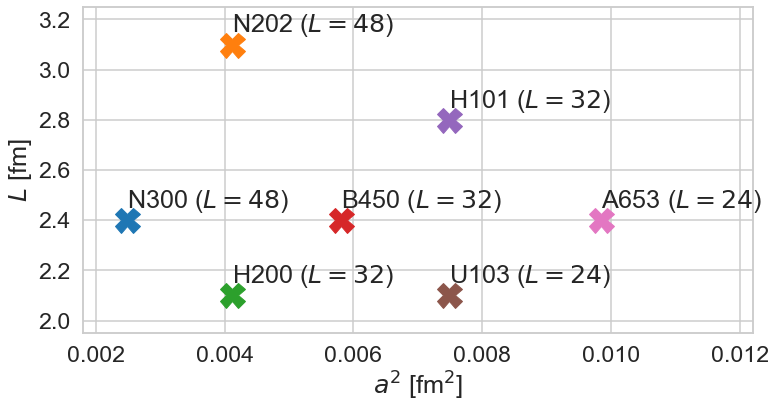

In [4]:
# for utility
lat_unit_dic = df_conf.set_index('Label')['a [fm]'].to_dict()
a_inv_dic = df_conf.set_index('Label')['a_inv [GeV]'].to_dict()
L_fm_dic = df_conf.set_index('Label')['L [fm]'].to_dict()
L_dic = df_conf.set_index('Label')['size_L'].to_dict()
pion_mass_dic = df_conf.set_index('Label')['m_pi [MeV]'].to_dict()
baryon_mass_dic = df_conf.set_index('Label')['m_B [GeV]'].to_dict()
label_list = list(df_conf['Label'])

with sns.color_palette('tab10'):
    fig, ax = plt.subplots(figsize=(12, 6))
    for label in label_list:
        if label in ['E5', 'E1']: continue
        a2 = lat_unit_dic.get(label)**2
        L_fm = L_fm_dic.get(label)
        ax.plot(a2, L_fm, 'X', ms=25)
        ax.text(a2, L_fm+0.05, fr'{label} ($L = {L_dic.get(label)}$)')
    ax.set(xlabel=r'$a^2$ [fm$^2$]', ylabel='$L$ [fm]', xlim=(0.0018, 0.0122), ylim=(1.95, 3.25))
#    fig.savefig('../figs/SU3_ensembles.png', bbox_inches='tight')

In [5]:
ld_dic = {}
for fname in glob.glob('../data/pcot_p2/*.json'):
    with open(fname, 'r') as fin:
        tmp = json.load(fin)
        ld_dic[(tmp.get('label'), tmp.get('frame'), tmp.get('level'))] = tmp

In [6]:
color_list = {'P000': 'dimgray', 'P001': 'firebrick', 'P011': 'darkorange', 'P111': 'mediumturquoise', 'P002': 'ghostwhite'}

In [7]:
def plot_p2_vs_pcot(label, xlim, ylim):
    fig, ax = plt.subplots(figsize=(12, 6))
    for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
        c = color_list.get(frame)
        for level in [0, 1]:
            try:
                ld = ld_dic[(label, frame, level)]

                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                sym = {0: 'o', 1: 'X'}[level]
                ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, label=f'{label} ({frame}) {level}')
                ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')


            except:
                pass
            
    if xlim[0] < 0:
        xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
        ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm])')
#    fig.savefig(f'../figs/pcot_vs_p2/{label}_pcot_vs_p2.png', bbox_inches='tight') # , transparent=True)


for convenience, we consider N202 ensemble

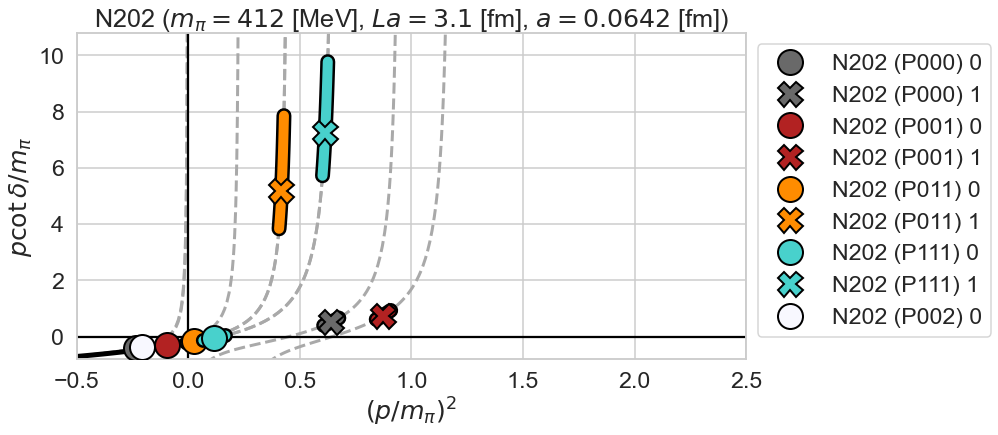

In [8]:
label = 'N202'
xlim, ylim = (-0.5, 2.5), (-0.8, 10.8)
plot_p2_vs_pcot(label, xlim, ylim)

In [9]:
def calc_ERE_chisq(fit_key_list, ere_prm, ylim):
    ere = lambda k2: ere_prm[0] + 0.5*ere_prm[1]*k2
    
    chisq = 0
    
    for key in fit_key_list:
        ld = ld_dic.get(key)

        xs, ys = np.array(ld.get('k2mpi2_ref')), np.array(ld.get('kcot_mpi_ref'))
        ymsk = (ys > ylim[0]) & (ys < ylim[1])
        ll = InterpolatedUnivariateSpline(xs[ymsk], ys[ymsk])

        intersect = lambda k2: ere(k2) - ll(k2)
        sol = scipy.optimize.root(intersect, ld.get('k2mpi2'))

        if sol.success:
            assert len(sol.x) == 1
            if sol.x[0] < ld.get('k2mpi2'):
                chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(ld.get('k2mpi2') - np.min(ld.get('k2mpi2s')))**2
            else:
                chisq += (sol.x[0] - ld.get('k2mpi2'))**2/(np.max(ld.get('k2mpi2s')) - ld.get('k2mpi2'))**2
        else:
            chisq = np.nan

    return chisq


In [10]:
fit_key_list = [('N202', 'P000', 0), ('N202', 'P001', 0), ('N202', 'P011', 0), ('N202', 'P111', 0), ('N202', 'P002', 0),
           ('N202', 'P000', 1), ('N202', 'P001', 1)]

fitting with 1st excited state for P000 and P001

In [11]:
def EREprm_to_k2ast(a0inv, reff):
    """
    return intersection between ERE and binding state condition in pion mass unit
    """
    k2ast = (-2*(reff*a0inv + 1) + 2 * np.sqrt((reff*a0inv+1)**2 - reff**2*a0inv**2))/(reff**2)

    return k2ast

def k2ast_to_BE(k2ast, label='N202'):

    return  - (
        2 * np.sqrt(k2ast*pion_mass_dic.get(label)**2 + (baryon_mass_dic.get(label)*1e3)**2) 
        - 2 * baryon_mass_dic.get(label)*1e3
    )

In [12]:
ere_prm = [-0.21, 1.68]

calc_ERE_chisq(fit_key_list, ere_prm, ylim=(-0.8, 2))

14.350645594490242

In [13]:
def ERE_fit_and_plot_params(a0inv_lim, reff_lim, mesh_num=100, fit_key_list=fit_key_list, ylim=(-0.8, 2)):
    a0invs = np.linspace(a0inv_lim[0], a0inv_lim[1], mesh_num)
    reffs = np.linspace(reff_lim[0], reff_lim[1], mesh_num)

    chisq_ere = np.array([[calc_ERE_chisq(fit_key_list, [a0inv, reff], ylim), a0inv, reff] for a0inv in a0invs for reff in reffs])


    fig, ax = plt.subplots()

    chisq_min, a0inv0, reff0 = chisq_ere[np.nanargmin(chisq_ere[:,0]),:]
    ax.plot(a0inv0, reff0, 'X', color='blue', mew=2, mec='white', ms=35,
           label=f'({a0inv0:.2f}, {reff0:.2f})')

    zz = np.copy(chisq_ere[:,:].reshape(mesh_num,mesh_num,3))
    mask = zz[:,:,0] > chisq_min + 2.3 # for 2 parameters
    zz[:,:,0][mask] = np.nan

    cb = ax.contourf(zz[:,:,1], zz[:,:,2], zz[:,:,0]-chisq_min, np.linspace(0, 0+2.3,100),
                    cmap=cm.inferno)
    cb.set_clim(0,2.3)
    fig.colorbar(cb, ticks=[0,0.5,1.0,1.5,2.0])

    
    k2ast_av = EREprm_to_k2ast(a0inv0, reff0)
    mask2 = chisq_ere[:,0] <= chisq_min + 2.3
    k2ast_bs = EREprm_to_k2ast(chisq_ere[mask2,1],chisq_ere[mask2,2])
    k2ast_lower, k2ast_upper = np.min(k2ast_bs), np.max(k2ast_bs)

    BE_av = k2ast_to_BE(k2ast_av)
    BE_lower = k2ast_to_BE(k2ast_upper)
    BE_upper = k2ast_to_BE(k2ast_lower)

    label = fit_key_list[0][0]
    ax.set_title(rf'{label} ERE parameter (with P000 & P001 excited states)' + '\n' + rf'$\chi^2 - \chi^2_\mathrm{{min}}(={chisq_min:.2f})$'
        + '\n' + rf'$\mathrm{{B.E.}} = {BE_av:.2f}(_{{{BE_lower-BE_av:+.2f}}}^{{{BE_upper-BE_av:+.2f}}})$ [MeV]')
    ax.set_xlabel(r'$(a_0m_\pi)^{-1}$')
    ax.set_ylabel(r'$r_\mathrm{eff}m_\pi$')
    leg = ax.legend(frameon=True)
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(2.0)
    
    fig.savefig(f'../figs/first_excited_state/{label}_ERE_param_with_P000_1_P001_1.png', bbox_inches='tight')
    return chisq_ere, (k2ast_av, k2ast_lower, k2ast_upper), (BE_av, BE_lower, BE_upper)

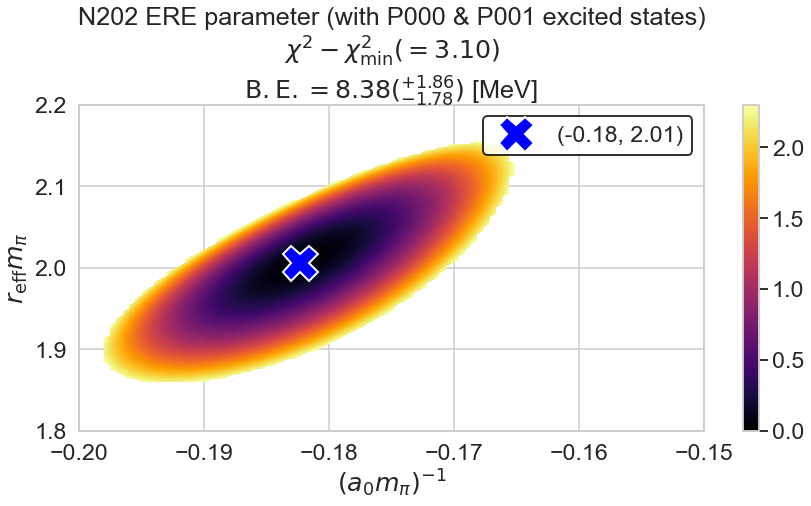

In [14]:
chisq_ere, k2ast_vals, BE_vals = ERE_fit_and_plot_params((-0.20,-0.15), (1.8, 2.2))

In [15]:
def plot_k2_vs_kcot_with_ERE(xlim, ylim, chisq_ere, k2ast_vals, BE_vals, label='N202', suffix=''):
    
    k2ast_av, k2ast_lower, k2ast_upper = k2ast_vals
    BE_av, BE_lower, BE_upper = BE_vals
    
    ere_k2s = np.linspace(xlim[0], xlim[1])
    mask = chisq_ere[:,0] <= np.nanmin(chisq_ere[:,0]) + 2.3
    ere_upper = []
    ere_lower = []
    allowed_a0invs = chisq_ere[mask,1]
    allowed_reffs = chisq_ere[mask,2]
    ere_t = lambda p0, p1, k2: p0 + 0.5*p1*k2

    for k2 in ere_k2s:
        ere_upper.append(np.max(ere_t(allowed_a0invs, allowed_reffs, k2)))
        ere_lower.append(np.min(ere_t(allowed_a0invs, allowed_reffs, k2)))


    fig, ax = plt.subplots(figsize=(12,6))

    for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
        c = color_list.get(frame)
        try:
            for level in [0, 1]:
                ld = ld_dic.get((label, frame, level))

                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
                ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

                sym = {0: 'o', 1: 'X'}[level]
                ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, 
                        label=f'{label} ({frame}) {level}')
                ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')
        except:
            pass


    ax.fill_between(ere_k2s, ere_upper, ere_lower, color='royalblue', alpha=0.2, zorder=3, label='ERE')
    ax.plot(ere_k2s, ere_upper, color='royalblue', lw=1, zorder=3)
    ax.plot(ere_k2s, ere_lower, color='royalblue', lw=1, zorder=3)


    xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
    ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

    ax.plot(k2ast_av, - np.sqrt(-k2ast_av), 'P', ms=25, color='palegreen', zorder=5, mew=2, mec='black',
           label=rf'${BE_av:.2f}(_{{{BE_lower - BE_av:+.2f}}}^{{{BE_upper-BE_av:+.2f}}})$ [MeV]')
    k2asts = np.linspace(k2ast_lower, k2ast_upper)
    ax.plot(k2asts, - np.sqrt(-k2asts), lw=15, color='black')
    ax.plot(k2asts, - np.sqrt(-k2asts), lw=10, color='palegreen')

    ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
          title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm]')
    fig.savefig(f'../figs/first_excited_state/{label}_p2_vs_pcot_with_ERE{suffix}.png', bbox_inches='tight')

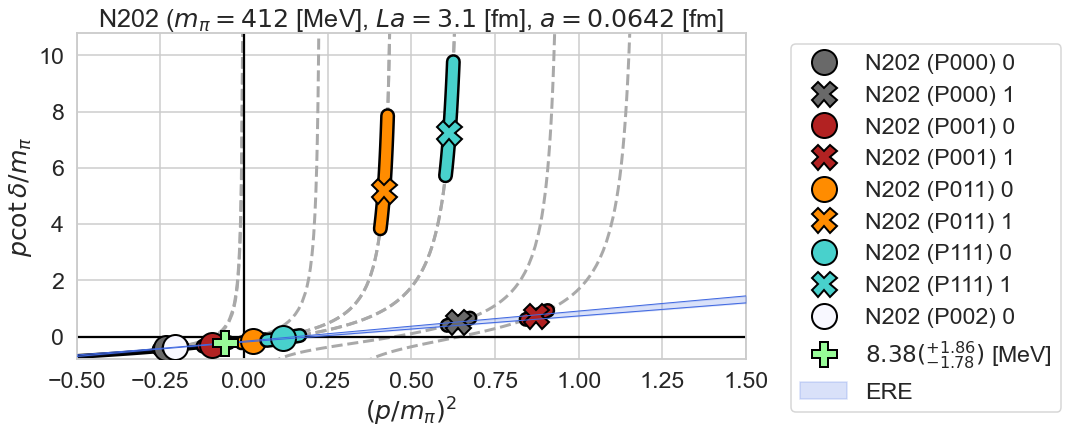

In [16]:
plot_k2_vs_kcot_with_ERE(xlim=(-0.5,1.5), ylim=(-0.8, 10.8), chisq_ere=chisq_ere, k2ast_vals=k2ast_vals, BE_vals=BE_vals,
                        suffix='')

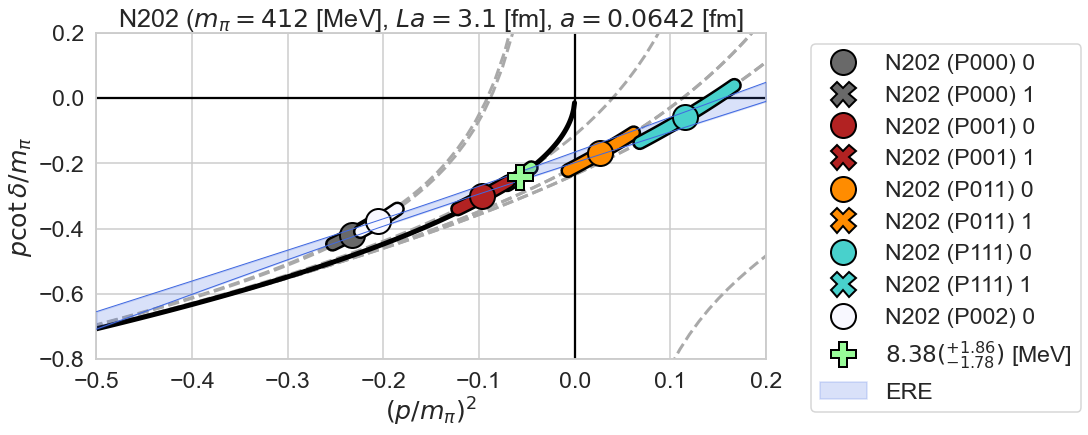

In [17]:
plot_k2_vs_kcot_with_ERE(xlim=(-0.5,0.2), ylim=(-0.8,0.2), chisq_ere=chisq_ere, k2ast_vals=k2ast_vals, BE_vals=BE_vals,
                        suffix='_neg')

In [18]:
class LD_imag(object):
    def __init__(self, label, frame, level, k2mpi2, k2mpi2_min, k2mpi2_max):
        self.label = label
        self.frame = frame
        self.level = level
        self.d = [int(frame[1]), int(frame[2]), int(frame[3])]
        self.L = L_dic.get(label)
        self.lat_unit = lat_unit_dic.get(label)
        self.a_inv = a_inv_dic.get(label)
        self.m_B = baryon_mass_dic.get(label)/self.a_inv
        self.m_pi = pion_mass_dic.get(label)/self.a_inv * 1e-3
        
        self.kcs = Kcot_luscher(self.L, self.m_B, self.m_B, d=self.d)
                
        # error bar
        self.k2mpi2s = np.linspace(k2mpi2_min, k2mpi2_max)
        self.kcot_mpis = np.array([self.kcs.kcot(k2 * self.m_pi**2)/self.m_pi for k2 in self.k2mpi2s])
        # central value
        self.k2mpi2 = k2mpi2
        self.kcot_mpi = self.kcs.kcot(k2mpi2 * self.m_pi**2) / self.m_pi
        
    def generate_reference_line(self, xlim, ylim, dk2=0.01, point_max=250, delta_y_limit=0.5):
        self.xlim = xlim
        self.ylim = ylim
        def _gen_reference_line(x0, y0, dk2):
            _k2mpi2_ref = [x0]
            _kcot_mpi_ref = [y0]
            for i in range(point_max):
                x1 = x0 + dk2
                y1 = self.kcs.kcot(x1 * self.m_pi**2)/self.m_pi
                
                if np.abs(y1 - y0) > delta_y_limit:
                    dk2 /= 2
                    continue
                    
                _k2mpi2_ref.append(x1)
                _kcot_mpi_ref.append(y1)
                                
                if (y1 >= ylim[1]) or (y1 <= ylim[0]):
                    break
                if (x1 >= xlim[1]) or (x1 <= xlim[0]):
                    break

                x0, y0 = x1, y1
            return _k2mpi2_ref, _kcot_mpi_ref

        _k2mpi2_ref_1, _kcot_mpi_ref_1 = _gen_reference_line(self.k2mpi2, self.kcot_mpi, dk2)
        _k2mpi2_ref_2, _kcot_mpi_ref_2 = _gen_reference_line(self.k2mpi2, self.kcot_mpi, - dk2)
        
        self.k2mpi2_ref = np.concatenate([_k2mpi2_ref_2[1:][::-1], _k2mpi2_ref_1])
        self.kcot_mpi_ref = np.concatenate([_kcot_mpi_ref_2[1:][::-1], _kcot_mpi_ref_1])
        

prepare finite volume line

In [19]:
ld_imag_dic = {}

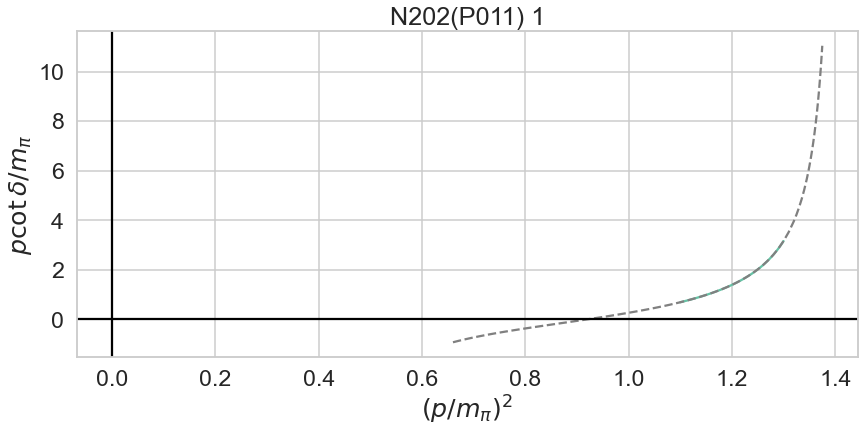

In [20]:
label = 'N202'
frame = 'P011'
level = 1
ld = LD_imag(label, frame, level, 1.2, 1.1, 1.3)

ld.generate_reference_line((0.5, 1.4), (-0.9, 10.8))

fig, ax = plt.subplots()

ax.plot(ld.k2mpi2s, ld.kcot_mpis)
ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, '--', color='grey')

ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$', title=f'{label}({frame}) {level}')

ld_imag_dic[(label, frame, level)] = ld

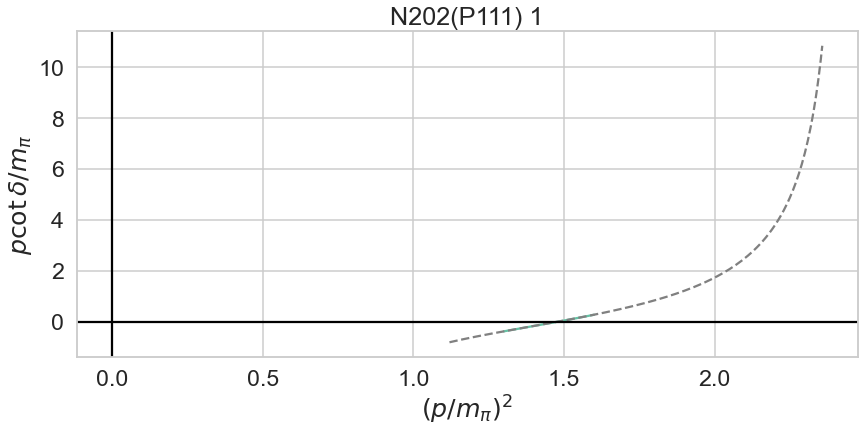

In [21]:
label = 'N202'
frame = 'P111'
level = 1
ld = LD_imag(label, frame, level, 1.4, 1.3, 1.6)

ld.generate_reference_line((1.0, 2.4), (-0.8, 10.8))

fig, ax = plt.subplots()

ax.plot(ld.k2mpi2s, ld.kcot_mpis)
ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, '--', color='grey')

ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$', title=f'{label}({frame}) {level}')

ld_imag_dic[(label, frame, level)] = ld

In [22]:
k2ast_av, k2ast_lower, k2ast_upper = k2ast_vals
BE_av, BE_lower, BE_upper = BE_vals

ere_k2s = np.linspace(xlim[0], xlim[1])
mask = chisq_ere[:,0] <= np.nanmin(chisq_ere[:,0]) + 2.3
ere_upper = []
ere_lower = []
allowed_ere_prm = chisq_ere[mask,1:]
allowed_a0invs = chisq_ere[mask,1]
allowed_reffs = chisq_ere[mask,2]
ere_t = lambda p0, p1, k2: p0 + 0.5*p1*k2

for k2 in ere_k2s:
    ere_upper.append(np.max(ere_t(allowed_a0invs, allowed_reffs, k2)))
    ere_lower.append(np.min(ere_t(allowed_a0invs, allowed_reffs, k2)))


In [23]:
allowed_ere_prm.shape

(2512, 2)

[(-0.8, 10.8),
 (-0.5, 2.5),
 Text(0.5, 0, '$(p/m_\\pi)^2$'),
 Text(0, 0.5, '$p\\cot\\delta/m_\\pi$'),
 Text(0.5, 1.0, 'N202 ($m_\\pi = 412$ [MeV], $La = 3.1$ [fm], $a = 0.0642$ [fm]')]

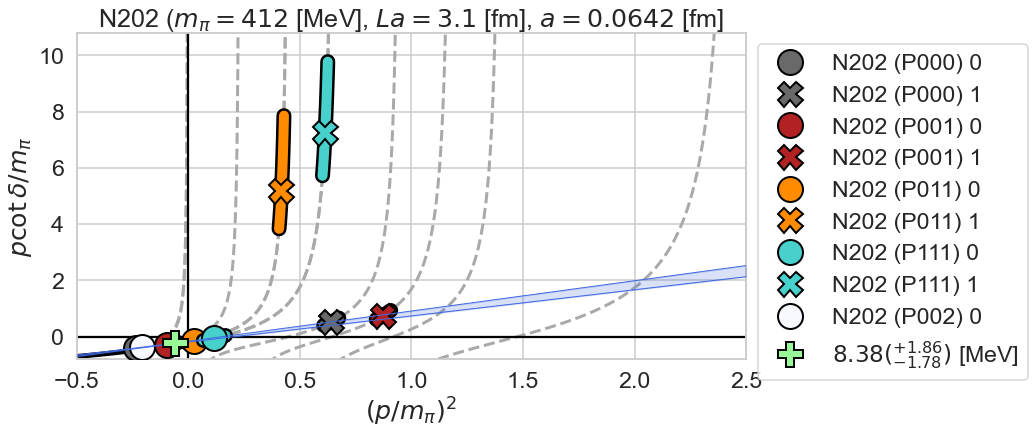

In [24]:
fig, ax = plt.subplots(figsize=(12,6))

for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
    c = color_list.get(frame)
    try:
        for level in [0, 1]:
            ld = ld_dic.get((label, frame, level))

            ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
            ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

            sym = {0: 'o', 1: 'X'}[level]
            ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, 
                    label=f'{label} ({frame}) {level}')
            ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')
    except:
        pass
    
for frame in ['P011', 'P111']:
    level = 1
    ld = ld_imag_dic[(label, frame, level)]
    ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, ls='--', lw=3, color='darkgray')


ax.fill_between(ere_k2s, ere_upper, ere_lower, color='royalblue', alpha=0.2, zorder=3)
ax.plot(ere_k2s, ere_upper, color='royalblue', lw=1, zorder=3)
ax.plot(ere_k2s, ere_lower, color='royalblue', lw=1, zorder=3)


xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

ax.plot(k2ast_av, - np.sqrt(-k2ast_av), 'P', ms=25, color='palegreen', zorder=5, mew=2, mec='black',
       label=rf'${BE_av:.2f}(_{{{BE_lower - BE_av:+.2f}}}^{{{BE_upper-BE_av:+.2f}}})$ [MeV]')
k2asts = np.linspace(k2ast_lower, k2ast_upper)
ax.plot(k2asts, - np.sqrt(-k2asts), lw=15, color='black')
ax.plot(k2asts, - np.sqrt(-k2asts), lw=10, color='palegreen')

ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
      title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm]')

In [25]:
image_spec_dic = {}

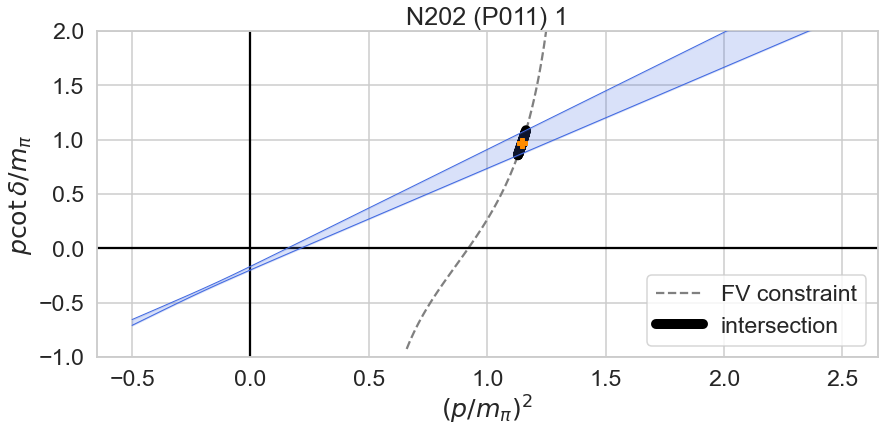

In [26]:
label = 'N202'
frame = 'P011'
level = 1

_ylim = (0, 1.5)
x0 = 1
ld = ld_imag_dic.get((label,frame,level))

xs = ld.k2mpi2_ref
ys = ld.kcot_mpi_ref
mask = (ys > _ylim[0]) & (ys < _ylim[1])
ll = InterpolatedUnivariateSpline(xs[mask],ys[mask])

ere = lambda k2, prm: prm[0] + 0.5 * prm[1]*k2

fig, ax = plt.subplots()


ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, '--', color='grey', label='FV constraint')

_xs = []
_ys = []
for ere_prm in allowed_ere_prm:
    intersect = lambda k2: ere(k2, ere_prm) - ll(k2)
    sol = scipy.optimize.root(intersect, x0)
    _xs.append(sol.x[0])
    _ys.append(ll(sol.x)[0])
    
ax.plot(_xs, _ys, ls='-', lw=10, color='black', label='intersection')

ere_min_prm = chisq_ere[np.nanargmin(chisq_ere[:,0]),:]
intersect = lambda k2: ere(k2, ere_min_prm[1:]) - ll(k2)
sol = scipy.optimize.root(intersect, x0)
_x = sol.x[0]
_y = ll(sol.x)[0]
ax.plot(_x, _y, 'P', ms=10, color='darkorange', zorder=3)

ax.fill_between(ere_k2s, ere_upper, ere_lower, color='royalblue', alpha=0.2, zorder=3)
ax.plot(ere_k2s, ere_upper, color='royalblue', lw=1, zorder=3)
ax.plot(ere_k2s, ere_lower, color='royalblue', lw=1, zorder=3)


ax.legend()
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(ylim=(-1, 2), xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$', title=f'{label} ({frame}) {level}')

image_spec_dic[(label,frame,level)] = {'x': _x, 'y': _y, 'xs': _xs, 'ys': _ys}

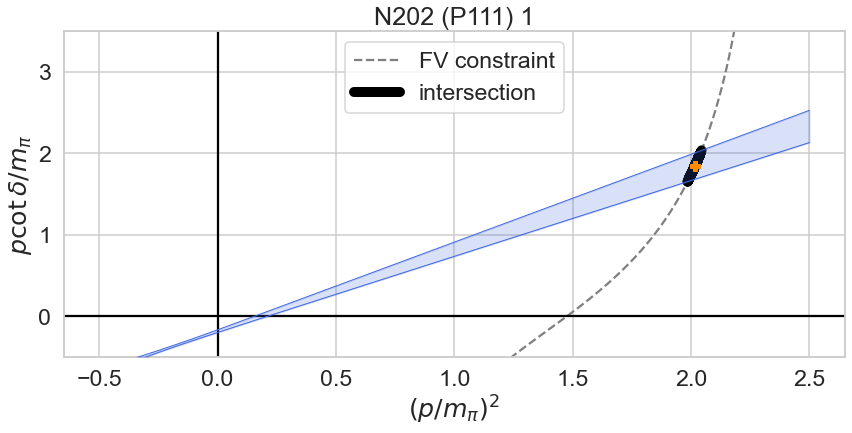

In [27]:
label = 'N202'
frame = 'P111'
level = 1

_ylim = (1, 3.5)
x0 = 1.5
ld = ld_imag_dic.get((label,frame,level))

xs = ld.k2mpi2_ref
ys = ld.kcot_mpi_ref
mask = (ys > _ylim[0]) & (ys < _ylim[1])
ll = InterpolatedUnivariateSpline(xs[mask],ys[mask])

ere = lambda k2, prm: prm[0] + 0.5 * prm[1]*k2

fig, ax = plt.subplots()


ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, '--', color='grey', label='FV constraint')

_xs = []
_ys = []
for ere_prm in allowed_ere_prm:
    intersect = lambda k2: ere(k2, ere_prm) - ll(k2)
    sol = scipy.optimize.root(intersect, x0)
    _xs.append(sol.x[0])
    _ys.append(ll(sol.x)[0])
    
ax.plot(_xs, _ys, ls='-', lw=10, color='black', label='intersection')

ere_min_prm = chisq_ere[np.nanargmin(chisq_ere[:,0]),:]
intersect = lambda k2: ere(k2, ere_min_prm[1:]) - ll(k2)
sol = scipy.optimize.root(intersect, x0)
_x = sol.x[0]
_y = ll(sol.x)[0]
ax.plot(_x, _y, 'P', ms=10, color='darkorange', zorder=3)

ax.fill_between(ere_k2s, ere_upper, ere_lower, color='royalblue', alpha=0.2, zorder=3)
ax.plot(ere_k2s, ere_upper, color='royalblue', lw=1, zorder=3)
ax.plot(ere_k2s, ere_lower, color='royalblue', lw=1, zorder=3)


ax.legend()
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(ylim=(-0.5, 3.5), xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$', title=f'{label} ({frame}) {level}')

image_spec_dic[(label,frame,level)] = {'x': _x, 'y': _y, 'xs': _xs, 'ys': _ys}

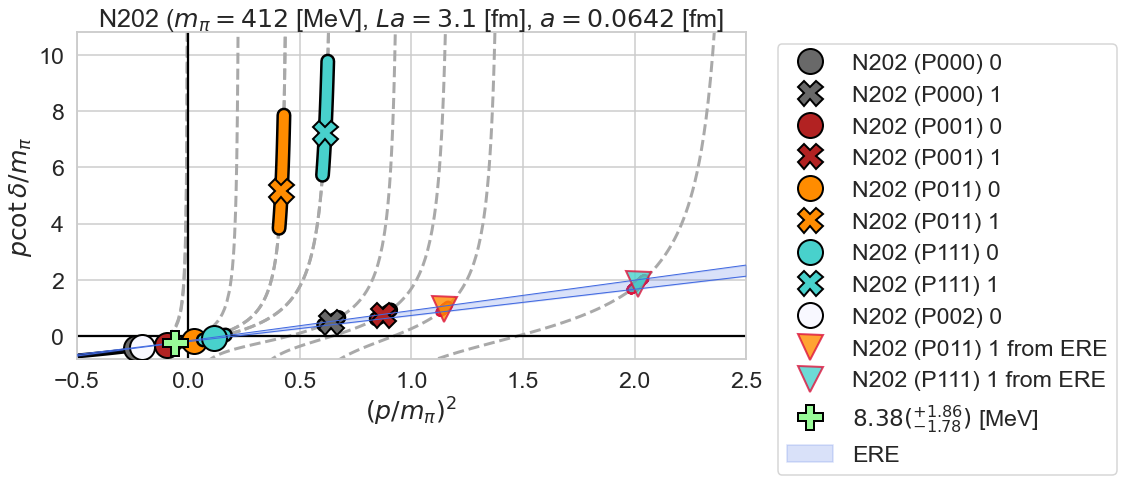

In [28]:
fig, ax = plt.subplots(figsize=(12,6))

for frame in ['P000', 'P001', 'P011', 'P111', 'P002']:
    c = color_list.get(frame)
    try:
        for level in [0, 1]:
            ld = ld_dic.get((label, frame, level))

            ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color='black', zorder=3, lw=15)
            ax.plot(ld.get('k2mpi2s'), ld.get('kcot_mpis'), color=c, zorder=3, lw=10)

            sym = {0: 'o', 1: 'X'}[level]
            ax.plot(ld.get('k2mpi2'), ld.get('kcot_mpi'), sym, ms=25, color=c, mec='black', mew=2, zorder=3, 
                    label=f'{label} ({frame}) {level}')
            ax.plot(ld.get('k2mpi2_ref'), ld.get('kcot_mpi_ref'), ls='--', lw=3, color='darkgray')
    except:
        pass
    
for frame in ['P011', 'P111']:
    level = 1
    ld = ld_imag_dic[(label, frame, level)]
    ax.plot(ld.k2mpi2_ref, ld.kcot_mpi_ref, ls='--', lw=3, color='darkgray')
    
    spec = image_spec_dic[(label,frame,level)]
    
    ax.plot(spec.get('x'), spec.get('y'), marker='v', ms=25, ls='', color=color_list.get(frame),
           mec='crimson', mew=2, zorder=3, label=f'{label} ({frame}) {level} from ERE', alpha=0.8)
    ax.plot(spec.get('xs'), spec.get('ys'), color='crimson', lw=10)
    ax.plot(spec.get('xs'), spec.get('ys'), color=color_list.get(frame), lw=5, alpha=0.8)


ax.fill_between(ere_k2s, ere_upper, ere_lower, color='royalblue', alpha=0.2, zorder=3, label='ERE')
ax.plot(ere_k2s, ere_upper, color='royalblue', lw=1, zorder=3)
ax.plot(ere_k2s, ere_lower, color='royalblue', lw=1, zorder=3)


xbs = np.concatenate([np.linspace(xlim[0], -0.5e-1), np.linspace(-0.5e-1, -2e-4)])
ax.plot(xbs, - np.sqrt(-xbs), color='black', ls='-', lw=5)

ax.plot(k2ast_av, - np.sqrt(-k2ast_av), 'P', ms=25, color='palegreen', zorder=5, mew=2, mec='black',
       label=rf'${BE_av:.2f}(_{{{BE_lower - BE_av:+.2f}}}^{{{BE_upper-BE_av:+.2f}}})$ [MeV]')
k2asts = np.linspace(k2ast_lower, k2ast_upper)
ax.plot(k2asts, - np.sqrt(-k2asts), lw=15, color='black')
ax.plot(k2asts, - np.sqrt(-k2asts), lw=10, color='palegreen')


ax.legend(loc='upper left', bbox_to_anchor=(1.03,1))
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set(ylim=ylim, xlim=xlim, xlabel=r'$(p/m_\pi)^2$', ylabel=r'$p\cot\delta/m_\pi$',
      title=rf'{label} ($m_\pi = {pion_mass_dic.get(label)}$ [MeV], $La = {L_fm_dic.get(label)}$ [fm], $a = {lat_unit_dic.get(label)}$ [fm]')

fig.savefig(f'../figs/first_excited_state/{label}_p2_vs_pcot_with_ERE_plus_excited_state_intersection.png', bbox_inches='tight')

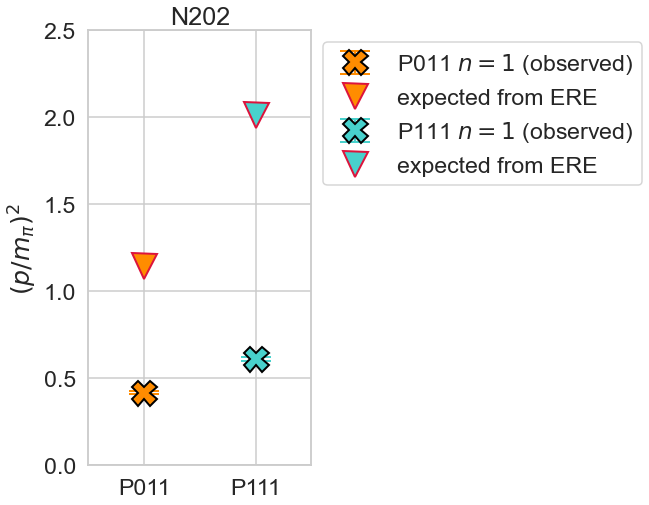

In [29]:
fig, ax = plt.subplots(figsize=(4, 8))

for ith, frame in enumerate(['P011', 'P111']):
    level = 1
    ld = ld_dic.get((label,frame,level))
    ax.errorbar([ith], [ld.get('k2mpi2')], yerr=[[ld.get('k2mpi2') - min(ld.get('k2mpi2s'))], [max(ld.get('k2mpi2s')) - ld.get('k2mpi2')]],
                    marker='X', ms=25, ls='', color=color_list.get(frame), mew=2, mec='black',
               capthick=5, capsize=15, label=f'{frame} $n=1$ (observed)')
    

    level = 1
    spec = image_spec_dic[(label,frame,level)]
    
    ax.errorbar([ith], [spec.get('x')], yerr=[[spec.get('x') - min(spec.get('xs'))], [max(spec.get('xs')) - spec.get('x')]],
               mec='crimson', mew=2, marker='v', ms=25, ls='', color=color_list.get(frame),
               label=f'expected from ERE')
    
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

ax.set(xlim=(-0.5, 1.5), xticks=[0,1], ylim=(0, 2.5), xticklabels=['P011', 'P111'], ylabel=r'$(p/m_\pi)^2$', 
      title=rf'{label}')

fig.savefig(f'../figs/first_excited_state/{label}_P011_plus_P111_1st_excited_state_spectra.png', bbox_inches='tight')